In [1]:
import LLMSR
import openai

import numpy as np
import matplotlib.pyplot as plt

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

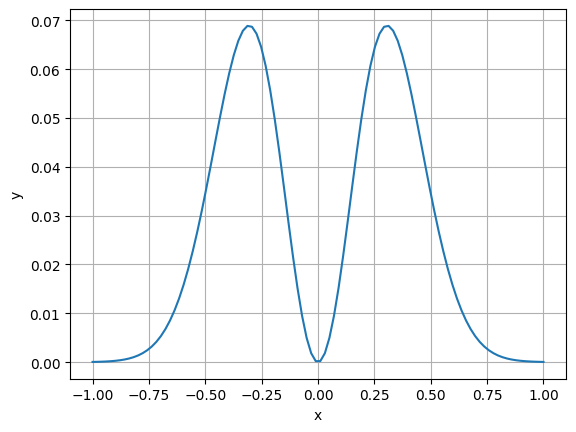

In [3]:
x = np.linspace(-1, 1, 100)
y = x*np.sin(2*x)*np.exp(-10 * x**2)
#y = np.tanh(3*x)

plt.plot(x, y,label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.legend()
plt.savefig('plot.png')

# Getting the Base64 string
base64_image = LLMSR.encode_image('plot.png')

In [4]:
r = LLMSR.single_call(client, base64_image, x, y, model="openai/gpt-4o-mini",function_list=None, system_prompt=None)
print(r)

{'params': array([1.34078757e+00, 5.10267338e-11]), 'score': np.float64(-1247.6231197370012), 'ansatz': 'np.exp(-params[0] * x**2) * np.sin(params[1] * x)', 'Num_params': 2, 'curve': <function <lambda> at 0x10fcf4fe0>, 'response': ChatCompletion(id='gen-1739979144-v3tzgvKlbVz4i1MsS8c3', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```python\nnp.exp(-params[0] * x**2) * np.sin(params[1] * x)\n```', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), native_finish_reason='stop')], created=1739979144, model='openai/gpt-4o-mini', object='chat.completion', service_tier=None, system_fingerprint='fp_13eed4fce1', usage=CompletionUsage(completion_tokens=27, prompt_tokens=664, total_tokens=691, completion_tokens_details=None, prompt_tokens_details=None), provider='OpenAI'), 'prompt': 'import numpy as np \ncurve_0 = lambda x,*params: x* params[0] + params[1] \ncurve_1 = lambda x,*params:', 'function_list': None}

In [5]:
population_size = 10
num_of_generations = 2
start = LLMSR.check_key_limit(client)
res = LLMSR.run_genetic(client, base64_image, x, y, population_size,num_of_generations, 
                        temperature=0.1, model="openai/gpt-4o", system_prompt=None, elite=False)
print(f"Credits spent: {start - LLMSR.check_key_limit(client)}")

Generating Initial population population


 30%|███       | 3/10 [00:07<00:16,  2.43s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


Best score:  -0.010313726490059499
Best ansatz:   params[0] * np.exp(-params[1] * (x - params[2])**2) + params[3] * np.exp(-params[4] * (x - params[5])**2)
Best params:  [-8.21988038e-01 -6.25012610e-02  8.04596811e-04  8.65417384e-01
  1.75028309e-03 -2.84602460e-02]
Generation: 1


 60%|██████    | 6/10 [00:33<00:24,  6.23s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


100%|██████████| 10/10 [01:15<00:00,  7.51s/it]


Best score:  -0.010264279651334932
Best ansatz:   params[0] * np.sin(params[1] * x + params[2]) + params[3] * np.sin(params[4] * x + params[5])
Best params:  [-1.13236619e+00  2.52477192e-05  1.72170717e+00  1.16310716e+00
  3.06649116e-01  1.57080939e+00]
Credits spent: 0.06774750000001006


In [13]:
len(res[0])

10

In [10]:
highest_score_element = max(res[0], key=lambda item: item['score'])
print(highest_score_element)

{'params': array([-8.21988038e-01, -6.25012610e-02,  8.04596811e-04,  8.65417384e-01,
        1.75028309e-03, -2.84602460e-02]), 'score': np.float64(-0.010313726490059499), 'ansatz': ' params[0] * np.exp(-params[1] * (x - params[2])**2) + params[3] * np.exp(-params[4] * (x - params[5])**2)', 'Num_params': 6, 'curve': <function <lambda> at 0x10fc41760>, 'response': ChatCompletion(id='gen-1739979160-LXPvczKzn8Ns6EMh9Vyh', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```python\ncurve_1 = lambda x, *params: params[0] * np.exp(-params[1] * (x - params[2])**2) + params[3] * np.exp(-params[4] * (x - params[5])**2)\n```\n\nThis function represents the sum of two Gaussian curves, each defined by parameters for amplitude, width, and center.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), native_finish_reason='stop')], created=1739979160, model='openai/gpt-4o', object='chat.completion', service_tier=None, 

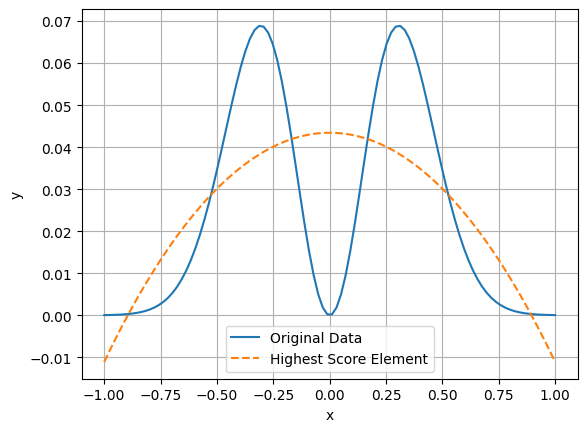

In [7]:
# Extract the parameters and the ansatz function from the highest_score_element
params = highest_score_element['params']
ansatz = highest_score_element['ansatz']

# Define the ansatz function
def ansatz_function(x, params):
    return eval(ansatz)

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the highest score element
plt.plot(x, ansatz_function(x, params), label='Highest Score Element', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()